In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


# Step 1: Setup and Install Libraries


In [6]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 55.4 MB/s eta 0:00:00:00:0100:01


In [22]:
# --- 1. SETUP AND INSTALL LIBRARIES ---
# Standard library imports
import os
import ast # For safely evaluating string representations of lists/dicts
import time

# Third-party library imports
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# For embeddings
from sentence_transformers import SentenceTransformer

# For vector store
import faiss

# For LLM - using ctransformers for GGUF models
# Make sure Hugging Face Hub is available for model download
!pip install -q ctransformers[cuda] sentence-transformers pandas numpy huggingface_hub
# If faiss-gpu install fails, try faiss-cpu, but GPU is much faster for building the index

print("Libraries installed and imported.")

# Configuration
# Limit the number of recipes for faster processing during development/testing
# For the full dataset, set this to None or a large number (e.g., 230000)
# For one day, starting with a smaller subset is wise for iteration speed.
# Let's try 50k to get a reasonable pool. If too slow, reduce to 10k.
# If all goes well, you can try increasing it or setting to None for the final run.
MAX_RECIPES = 200000 # Or None for all recipes

# Embedding model
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2' # Fast and decent quality

# LLM Model (Mistral 7B GGUF)
# Using a quantized model to fit in memory. Q4_K_M is a good balance.
# Find models here: https://huggingface.co/TheBloke
LLM_MODEL_REPO = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
LLM_MODEL_FILE = "mistral-7b-instruct-v0.2.Q4_K_M.gguf" # Or other quantization

# FAISS Index path
FAISS_INDEX_PATH = "recipe_index.faiss"
RECIPE_DATA_PATH = "recipes_with_ids.parquet" # To store processed recipe data alongside FAISS

# Set up Hugging Face Hub token if needed for downloads (usually not for GGUF via huggingface_hub)
# from huggingface_hub import login
# login("YOUR_HF_TOKEN") # Optional, if you face download issues

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Libraries installed and imported.


# Step 2: Load and Preprocess Data

In [23]:
# --- 2. LOAD AND PREPROCESS DATA ---
def load_and_preprocess_data():
    print("Loading dataset...")
    # Adjust path based on your Kaggle dataset input directory
    # Usually '/kaggle/input/food-com-recipes-and-interactions/RAW_recipes.csv'
    try:
        df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
    except FileNotFoundError:
        print("ERROR: RAW_recipes.csv not found. Check dataset path in Kaggle.")
        return None

    print(f"Loaded {len(df)} recipes.")

    # Handle missing values (simple fill for this MVP)
    df['name'] = df['name'].fillna('Unnamed Recipe')
    df['description'] = df['description'].fillna('No description available.')
    # Crucial: ingredients and steps are strings representing lists.
    # We need to parse them.
    df['ingredients'] = df['ingredients'].fillna("[]")
    df['steps'] = df['steps'].fillna("[]")

    # Reduce dataset size if MAX_RECIPES is set
    if MAX_RECIPES is not None and MAX_RECIPES < len(df):
        print(f"Subsetting to {MAX_RECIPES} recipes for faster processing.")
        df = df.sample(n=MAX_RECIPES, random_state=42).reset_index(drop=True)

    processed_recipes = []
    print("Preprocessing recipes...")
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            # Safely evaluate string representations of lists
            ingredients_list = ast.literal_eval(row['ingredients'])
            steps_list = ast.literal_eval(row['steps'])

            ingredients_str = ", ".join(ingredients_list)
            steps_str = "\n".join([f"{i+1}. {step}" for i, step in enumerate(steps_list)])

            # Create a combined text for embedding
            # This text will be used by the retrieval model
            combined_text = f"Recipe Title: {row['name']}\n\n" \
                            f"Description: {row['description']}\n\n" \
                            f"Ingredients: {ingredients_str}\n\n" \
                            f"Instructions:\n{steps_str}"

            processed_recipes.append({
                'id': row['id'], # Keep original ID for mapping
                'name': row['name'],
                'ingredients_str': ingredients_str,
                'steps_str': steps_str,
                'combined_text_for_embedding': combined_text,
                'minutes': row['minutes'],
                'n_steps': row['n_steps'],
                'n_ingredients': row['n_ingredients']
            })
        except Exception as e:
            # print(f"Skipping recipe id {row.get('id', 'Unknown')} due to parsing error: {e}")
            # In a real scenario, log this or handle more gracefully
            pass
    
    recipes_df = pd.DataFrame(processed_recipes)
    print(f"Successfully processed {len(recipes_df)} recipes.")
    
    # Save processed data (important for mapping FAISS results back to recipe details)
    recipes_df.to_parquet(RECIPE_DATA_PATH, index=False)
    print(f"Processed recipe data saved to {RECIPE_DATA_PATH}")
    
    return recipes_df

# Execute preprocessing
recipes_df = load_and_preprocess_data()

if recipes_df is not None:
    print("\nSample of processed data:")
    print(recipes_df.head())
    print(f"\nSample combined text for recipe ID {recipes_df.iloc[0]['id']}:\n")
    print(recipes_df.iloc[0]['combined_text_for_embedding'])
else:
    print("Data loading failed. Cannot proceed.")

Loading dataset...
Loaded 231637 recipes.
Subsetting to 200000 recipes for faster processing.
Preprocessing recipes...


  0%|          | 0/200000 [00:00<?, ?it/s]

Successfully processed 200000 recipes.
Processed recipe data saved to recipes_with_ids.parquet

Sample of processed data:
       id                                               name  \
0   94947                        crab filled crescent snacks   
1  429010                                 curried bean salad   
2  277542                delicious steak with onion marinade   
3   78450                        pork tenderloin with hoisin   
4   80012  mixed baby greens with oranges  grapefruit and...   

                                     ingredients_str  \
0  crabmeat, cream cheese, green onions, garlic s...   
1  garbanzo beans, black beans, onion, ginger pas...   
2  olive oil, red onion, light brown sugar, balsa...   
3  pork tenderloin, soy sauce, hoisin sauce, rice...   
4  mixed baby greens, oranges, grapefruit, avocad...   

                                           steps_str  \
0  1. heat over to 375 degrees\n2. spray large co...   
1  1. drain & rinse beans\n2. stir all ingre

# Step 3: Embedding and FAISS Indexing

In [24]:
# --- 3. EMBEDDING AND FAISS INDEXING ---
def build_faiss_index(recipes_df, embedding_model_name, index_path):
    if recipes_df is None or recipes_df.empty:
        print("No recipe data to index.")
        return None

    print(f"Loading embedding model: {embedding_model_name}")
    # Use CUDA if available
    model = SentenceTransformer(embedding_model_name, device='cuda' if torch.cuda.is_available() else 'cpu')
    
    texts_to_embed = recipes_df['combined_text_for_embedding'].tolist()
    
    print(f"Generating embeddings for {len(texts_to_embed)} recipes... (This might take a while)")
    # Ensure texts are not excessively long, though MiniLM is robust
    # For longer texts, you might need to chunk or truncate
    embeddings = model.encode(texts_to_embed, show_progress_bar=True, batch_size=128) # Increased batch_size

    embedding_dim = embeddings.shape[1]
    print(f"Embeddings generated. Shape: {embeddings.shape}")

    print("Building FAISS index...")
    # Using IndexFlatL2, a common choice. For very large datasets, more complex indexes might be better.
    index = faiss.IndexFlatL2(embedding_dim)
    
    # For GPU usage (ensure faiss-gpu is installed and CUDA is available)
    if faiss.get_num_gpus() > 0:
        print("Using GPU for FAISS index.")
        res = faiss.StandardGpuResources() # use a single GPU
        index = faiss.index_cpu_to_gpu(res, 0, index) # transfer index to GPU
    else:
        print("Using CPU for FAISS index.")
        
    index.add(np.array(embeddings, dtype=np.float32)) # Add embeddings to index
    
    print(f"FAISS index built. Total vectors in index: {index.ntotal}")
    
    # Save the index
    if faiss.get_num_gpus() > 0:
        # If index is on GPU, must transfer back to CPU to save with faiss.write_index
        cpu_index = faiss.index_gpu_to_cpu(index)
        faiss.write_index(cpu_index, index_path)
    else:
        faiss.write_index(index, index_path)
        
    print(f"FAISS index saved to {index_path}")
    return index, model # Return model too, as it's needed for query embedding

# Check if pre-built index exists to save time
if os.path.exists(FAISS_INDEX_PATH) and os.path.exists(RECIPE_DATA_PATH):
    print("Loading existing FAISS index and processed data...")
    # Ensure torch is imported if not already for device check
    import torch
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME, device='cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load FAISS index
    faiss_index = faiss.read_index(FAISS_INDEX_PATH)
    if faiss.get_num_gpus() > 0:
        print("Moving FAISS index to GPU.")
        res = faiss.StandardGpuResources()
        faiss_index = faiss.index_cpu_to_gpu(res, 0, faiss_index)
    
    # Load processed recipe data
    recipes_df_loaded = pd.read_parquet(RECIPE_DATA_PATH)
    print(f"Loaded {faiss_index.ntotal} vectors from FAISS index and {len(recipes_df_loaded)} recipes from Parquet.")
    if recipes_df is None: # If recipes_df wasn't loaded in step 2 (e.g. kernel restart)
        recipes_df = recipes_df_loaded
elif recipes_df is not None and not recipes_df.empty:
    import torch # Ensure torch is available for device check
    faiss_index, embedding_model = build_faiss_index(recipes_df, EMBEDDING_MODEL_NAME, FAISS_INDEX_PATH)
else:
    print("Recipe data is not available. Cannot build or load FAISS index.")
    faiss_index = None
    embedding_model = None
    recipes_df_loaded = None # Ensure this is defined

# To ensure recipes_df is the one aligned with the index (if loaded from file)
if 'recipes_df_loaded' in locals() and recipes_df_loaded is not None:
    recipes_df = recipes_df_loaded

Loading existing FAISS index and processed data...
Loaded 50000 vectors from FAISS index and 200000 recipes from Parquet.


# Step 4: Load LLM (Mistral-7B GGUF)

In [25]:
# --- 4. LOAD LLM (Mistral-7B GGUF using CTransformers) ---
from ctransformers import AutoModelForCausalLM
from huggingface_hub import hf_hub_download
import gc # Garbage collector

llm = None

def load_llm():
    global llm
    print("Downloading and loading LLM...")
    try:
        # Download the GGUF model file from Hugging Face Hub
        model_path = hf_hub_download(repo_id=LLM_MODEL_REPO, filename=LLM_MODEL_FILE)
        print(f"Model downloaded to: {model_path}")

        # Configuration for ctransformers
        # Adjust gpu_layers for your GPU VRAM. 0 means all on CPU.
        # For a T4 (~15-16GB VRAM), you can often offload many layers.
        # Start with a moderate number like 20-30 and adjust if you get OOM errors or its too slow.
        # If you have less VRAM (e.g., 8GB), try fewer layers (e.g., 10-15).
        config = {
            'max_new_tokens': 1024, # Max tokens to generate
            'repetition_penalty': 1.1,
            'temperature': 0.3, # Controls randomness. Lower for more factual.
            'stream': False, # Set to True for streaming output if desired in an app
            'context_length': 4096 # Mistral's context window. GGUF might have its own default.
        }
        
        # Try to load with GPU layers. If it fails, fall back to CPU.
        try:
            print("Attempting to load LLM with GPU layers...")
            llm = AutoModelForCausalLM.from_pretrained(
                model_path,
                model_type='mistral',
                gpu_layers=35, # Number of layers to offload to GPU. Adjust based on VRAM.
                **config
            )
            print("LLM loaded successfully with GPU layers.")
        except Exception as e_gpu:
            print(f"Failed to load LLM with GPU layers: {e_gpu}")
            print("Attempting to load LLM on CPU...")
            # If GPU loading fails (e.g. not enough VRAM, CUDA issues), try CPU
            # This will be very slow for inference but good for testing the pipeline
            llm = AutoModelForCausalLM.from_pretrained(
                model_path,
                model_type='mistral',
                gpu_layers=0, # All layers on CPU
                **config
            )
            print("LLM loaded successfully on CPU (inference will be slow).")
            
        print(f"LLM ({LLM_MODEL_FILE}) loaded.")
        return llm

    except Exception as e:
        print(f"Error loading LLM: {e}")
        return None

# Load the LLM (only if not already loaded)
if llm is None:
    llm = load_llm()

if llm:
    print("Testing LLM with a simple prompt...")
    try:
        # Mistral Instruct prompt format: <s>[INST] User Prompt [/INST] Model Response
        test_prompt = "<s>[INST] What is the capital of France? [/INST]"
        response = llm(test_prompt)
        print(f"LLM Test Response: {response}")
    except Exception as e:
        print(f"Error during LLM test: {e}")
else:
    print("LLM could not be loaded. RAG and Generation functionality will not work.")

# Clear CUDA cache if SentenceTransformer and LLM are both on GPU and memory is tight
if 'torch' in locals() and torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

Model downloaded to: /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q4_K_M.gguf
Attempting to load LLM with GPU layers...


ggml_cuda_set_main_device: using device 0 (Tesla T4) as main device


LLM loaded successfully with GPU layers.
LLM (mistral-7b-instruct-v0.2.Q4_K_M.gguf) loaded.
Testing LLM with a simple prompt...
LLM Test Response:  The capital city of France is Paris. Paris is one of the most famous cities in the world and is known for its iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and Montmartre. It is also home to numerous cultural institutions and is a major global center for art, fashion, gastronomy, science, and business.


5974

Simple preferance tracking 

In [33]:
# --- NEW: 3.4 Basic User Preferences Storage Simulation ---

# Simulate user data storage in memory
# In a real application, this would be a database
user_data = {
    'user1': {
        'favorites': [], # List of recipe IDs
        'preferences': { # Dictionary of preference types
            'dietary': [], # e.g., ['vegetarian', 'vegan', 'gluten-free']
            'cuisine': [], # e.g., ['italian', 'mexican']
            'allergies': [] # e.g., ['nuts', 'dairy']
        }
    }
    # Could add more users: 'user2': {...}
}

def add_favorite_recipe(user_id, recipe_id):
    """Simulates adding a recipe to a user's favorites."""
    if user_id in user_data:
        if recipe_id not in user_data[user_id]['favorites']:
            user_data[user_id]['favorites'].append(recipe_id)
            print(f"Recipe {recipe_id} added to {user_id}'s favorites.")
        else:
            print(f"Recipe {recipe_id} is already in {user_id}'s favorites.")
    else:
        print(f"User ID {user_id} not found.")

def remove_favorite_recipe(user_id, recipe_id):
     """Simulates removing a recipe from favorites."""
     if user_id in user_data:
         if recipe_id in user_data[user_id]['favorites']:
             user_data[user_id]['favorites'].remove(recipe_id)
             print(f"Recipe {recipe_id} removed from {user_id}'s favorites.")
         else:
             print(f"Recipe {recipe_id} not found in {user_id}'s favorites.")
     else:
         print(f"User ID {user_id} not found.")

def set_user_preferences(user_id, preferences):
    """Simulates setting a user's dietary and other preferences."""
    if user_id in user_data:
        # Simple merge - overwrite if key exists
        for key, value in preferences.items():
             if key in user_data[user_id]['preferences']:
                 user_data[user_id]['preferences'][key] = list(set(user_data[user_id]['preferences'][key] + value)) # Add unique items
             else:
                 user_data[user_id]['preferences'][key] = value
        print(f"Preferences set for {user_id}: {user_data[user_id]['preferences']}")
    else:
        print(f"User ID {user_id} not found.")

def get_user_data(user_id):
    """Retrieves user data."""
    return user_data.get(user_id, None)

# --- Test User Data Simulation ---
print("\n--- Testing User Data Simulation ---")
# Add a favorite recipe (use a real ID from your data if possible, or a dummy one)
# Find a real ID from recipes_df.head() output from Step 2 or 3
example_recipe_id = recipes_df.iloc[0]['id'] if recipes_df is not None and not recipes_df.empty else 1 # Use first recipe ID or 1
add_favorite_recipe('user1', example_recipe_id)
add_favorite_recipe('user1', 2) # Add another dummy favorite
add_favorite_recipe('user1', example_recipe_id) # Try adding again

# Set dietary preferences
set_user_preferences('user1', {'dietary': ['vegetarian', 'quick'], 'allergies': ['peanuts']})

# Get and print user data
print(get_user_data('user1'))


--- Testing User Data Simulation ---
Recipe 94947 added to user1's favorites.
Recipe 2 added to user1's favorites.
Recipe 94947 is already in user1's favorites.
Preferences set for user1: {'dietary': ['vegetarian', 'quick'], 'cuisine': [], 'allergies': ['peanuts']}
{'favorites': [94947, 2], 'preferences': {'dietary': ['vegetarian', 'quick'], 'cuisine': [], 'allergies': ['peanuts']}}


# Step 5: Implement Core Functions

## 5.1 Retrieval Function (Backend for Ingredient Search & RAG)

In [34]:
# --- 5. IMPLEMENT CORE FUNCTIONS (Updated with User Preferences & Comparison) ---
import time
import gc
# Ensure torch is imported if not already for device check
import torch
# Ensure ast is imported if not already
import ast
# Import matplotlib for plotting later (optional)
import matplotlib.pyplot as plt

# --- 5.1 Retrieval Function (Backend for Ingredient Search & RAG) ---
# (Kept mostly the same, might retrieve more docs for RAG)
def search_recipes(query, top_k=5):
    if faiss_index is None or embedding_model is None or recipes_df is None:
        print("FAISS index, embedding model, or recipe data not available. Cannot search.")
        return []

    # print(f"\nSearching for recipes similar to: '{query}'") # Keep silent for cleaner output during RAG
    query_embedding = embedding_model.encode([query], convert_to_tensor=False)

    # Perform the search
    distances, indices = faiss_index.search(np.array(query_embedding, dtype=np.float32), top_k)

    results = []
    # Ensure indices are flat and valid
    # FAISS search returns indices within the index, which map directly to recipes_df row indices
    valid_indices = [idx for idx in indices[0] if 0 <= idx < len(recipes_df)]

    for recipe_df_index in valid_indices:
        # Ensure we only add each recipe once if duplicates somehow appeared (unlikely with FAISS)
        recipe_details = recipes_df.iloc[recipe_df_index]
        recipe_id = recipe_details['id']
        # Check if recipe with this original ID is already in results to avoid duplicates if somehow indexed multiple times
        if not any(res['id'] == recipe_id for res in results):
            results.append({
                'id': recipe_id,
                'name': recipe_details['name'],
                # Note: This score is L2 distance based. Lower is better match.
                # For display/sorting, converting to similarity (1 - distance/max_distance) is often better.
                # Let's pass the distance directly.
                'distance': distances[0][np.where(indices[0] == recipe_df_index)[0][0]], # Find the distance corresponding to this index
                'ingredients': recipe_details['ingredients_str'],
                'steps': recipe_details['steps_str'],
                'combined_text': recipe_details['combined_text_for_embedding'] # For LLM context
            })

    # Optional: Sort by distance (lower distance is better) - FAISS results are already sorted by distance by default
    # results.sort(key=lambda x: x['distance'])

    # print(f"Found {len(results)} initial recipes.")
    return results

# Test Ingredient-Based Search (Function 3.3) - Still works as a standalone search
print("\n--- Function 3.3: Ingredient-Based Search Test ---")
ingredient_query_search = "broccoli cheddar soup"
retrieved_recipes_search = search_recipes(ingredient_query_search, top_k=5) # Get 5 results

if retrieved_recipes_search:
    print(f"Found {len(retrieved_recipes_search)} recipes for '{ingredient_query_search}':")
    for recipe in retrieved_recipes_search:
        print(f"- ID: {recipe['id']}, Name: {recipe['name']}, Distance: {recipe['distance']:.4f}")
else:
    print("No recipes found for the ingredient search query.")




--- Function 3.3: Ingredient-Based Search Test ---


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 5 recipes for 'broccoli cheddar soup':
- ID: 235519, Name: broccoli   cheddar soup, Distance: 0.3112
- ID: 11753, Name: wisconsin broccoli cheddar cheese soup, Distance: 0.3277
- ID: 230209, Name: cheddar broccoli chowder, Distance: 0.3881
- ID: 438230, Name: creamy broccoli and cheddar soup, Distance: 0.3933
- ID: 17510, Name: t g i f s broccoli cheese soup, Distance: 0.4146


## 5.2 Recipe Recommendation System (RAG - Function 3.2)

In [40]:
# --- 5.2 Recipe Recommendation System (RAG - Function 3.2 - IMPROVED with Preferences) ---
def recommend_recipe_with_rag_improved(user_id, user_query, top_k_retrieval=10): # Retrieve even more candidates
    if llm is None:
        print("LLM not loaded. Cannot perform RAG.")
        return "LLM is not available.", 0.0

    print(f"\n--- Generating RAG Recommendation for User '{user_id}' and Query: '{user_query}' ---")

    # Get user data
    user_prefs_data = get_user_data(user_id)
    user_preferences_str = ""
    user_favorites_str = ""

    if user_prefs_data:
        # Format preferences nicely for the prompt
        prefs = user_prefs_data.get('preferences', {})
        if prefs:
            pref_strings = []
            for key, values in prefs.items():
                if values:
                    pref_strings.append(f"{key}: {', '.join(values)}")
            if pref_strings:
                 user_preferences_str = "User's General Preferences: " + "; ".join(pref_strings) + "\n"

        favorites = user_prefs_data.get('favorites', [])
        if favorites:
             # Get names of favorite recipes to potentially include in prompt (optional, adds lookup overhead)
             # Simple version: just list IDs
             user_favorites_str = f"User's Favorite Recipe IDs: {', '.join(map(str, favorites))}\n"


    # 1. Retrieve potentially relevant recipes
    # We still retrieve based on the query embedding. The LLM will filter/prioritize based on preferences.
    retrieved_docs = search_recipes(user_query, top_k=top_k_retrieval)

    if not retrieved_docs:
        print("No initial recipes retrieved from search.")
        return "I couldn't find any recipes matching your query. Try being more specific or using different ingredients.", 0.0

    # 2. Construct context for the LLM (pass full combined text for better understanding)
    context_parts = []
    for i, doc in enumerate(retrieved_docs):
        # Add each retrieved recipe's combined text as a separate context block
        context_parts.append(f"<RECIPE_START id={doc['id']}> Recipe Title: {doc['name']}\n"
                             f"Ingredients: {doc['ingredients']}\n"
                             f"Instructions:\n{doc['steps']}\n"
                             f"<RECIPE_END>\n")

    # Combine context parts, ensuring not to exceed potential LLM context limits
    # For this MVP, simple join is used. A real system might need truncation/summarization.
    context_str = "\n".join(context_parts)

    # 3. Formulate IMPROVED prompt for Mistral Instruct (incorporating preferences)
    # Format: <s>[INST] instruction [/INST]
    prompt = f"""<s>[INST] You are an intelligent and helpful recipe recommendation assistant.
Your task is to find the BEST recipe among the following provided recipes that strictly matches the user's request, including any ingredients, dietary restrictions (like vegan, gluten-free, etc.), preferences (like quick, easy, healthy), or cuisine types mentioned in the query.

ADDITIONALLY, take into account the user's known preferences and favorite recipes, provided below. Prioritize recipes that align with these preferences and consider if any of the retrieved recipes are among their favorites (though you don't have details about the favorites themselves, just their IDs).

Analyze the provided recipes. Select the one that is the most relevant and suitable based on the user's query AND preferences. If no recipe perfectly matches ALL constraints and preferences, select the one that is the closest match and mention which constraints couldn't be fully met.

Present the selected recipe clearly with its Title, Ingredients, and Instructions. If you cannot find any relevant recipe among the provided context, state that you couldn't find a suitable recipe from the available options for the user's request.

User Query: "{user_query}"

{user_preferences_str}{user_favorites_str}

Provided Recipes Context (analyse these to find the best match based on query AND preferences):
{context_str}

Respond with the best matching recipe or inability to find one. Your response should be formatted clearly, starting with the recipe title.
[/INST]
"""

    print(f"Retrieved {len(retrieved_docs)} recipes. Sending context ({len(context_str)} chars) to LLM (first 500 chars of context):\n{context_str[:500]}...")

    # 4. Get LLM response
    try:
        start_time = time.time()
        # Ensure LLM is loaded before calling
        if llm:
            response = llm(prompt)
            end_time = time.time()
            rag_gen_time = end_time - start_time
            # Clean up memory after LLM call
            del response # Optional: if you are storing large responses temporarily
            gc.collect()
            if 'torch' in locals() and torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Re-run LLM to get response string for return
            # We do this twice to measure clean inference time after potential cache issues from first run
            # In a real app, you'd just call once
            start_time = time.time()
            response_str = llm(prompt)
            end_time = time.time()
            rag_gen_time = end_time - start_time # Capture the second, hopefully more stable time
            print(f"RAG LLM generation took {rag_gen_time:.2f} seconds (after potential cache warm-up).")

            return response_str, rag_gen_time
        else:
             return "LLM is not loaded.", 0.0
    except Exception as e:
        print(f"Error during LLM generation for RAG: {e}")
        # Clean up in case of error
        gc.collect()
        if 'torch' in locals() and torch.cuda.is_available():
            torch.cuda.empty_cache()
        return f"Sorry, I encountered an error while generating the recipe recommendation: {e}", 0.0


# Test IMPROVED RAG Recommendation (Function 3.2)
print("\n--- Function 3.2: Recipe Recommendation (RAG - IMPROVED) Test ---")

# Query with constraints
rag_query_constrained = "quick and easy vegan pasta recipe with tomatoes"
rag_recommendation_improved, rag_time_1 = recommend_recipe_with_rag_improved('user1',rag_query_constrained)
print("\n--- RAG Recommendation (IMPROVED) Output 1 ---")
print(rag_recommendation_improved)


# Another RAG query
rag_query_2 = "healthy chicken stir fry"
rag_recommendation_improved_2, rag_time_2 = recommend_recipe_with_rag_improved('user1',rag_query_2)
print("\n--- RAG Recommendation (IMPROVED) Output 2 ---")
print(rag_recommendation_improved_2)



--- Function 3.2: Recipe Recommendation (RAG - IMPROVED) Test ---

--- Generating RAG Recommendation for User 'user1' and Query: 'quick and easy vegan pasta recipe with tomatoes' ---


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 10 recipes. Sending context (7665 chars) to LLM (first 500 chars of context):
<RECIPE_START id=217366> Recipe Title: vegan sun dried tomato sauce  for pizza or pasta
Ingredients: white onion, garlic cloves, olive oil, sun-dried tomatoes, water, sea salt, basil, italian seasoning, artificial sweetener, red pepper flakes
Instructions:
1. place first three ingredients into food processor and "chop" roughly
2. set aside
3. boil tomatoes in water in a shallow pan
4. when tomatoes have softened , add them and any remaining liquid to the food processor and puree
5. add remaining...
RAG LLM generation took 18.12 seconds (after potential cache warm-up).

--- RAG Recommendation (IMPROVED) Output 1 ---
Based on the user's query for a quick and easy vegan pasta recipe with tomatoes, and their general preferences for vegetarian dishes and avoiding peanuts, the best matching recipe from the provided context is:

<RECIPE_START id=217366> Recipe Title: vegan sun dried tomato sauce for pizza 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 10 recipes. Sending context (7638 chars) to LLM (first 500 chars of context):
<RECIPE_START id=148287> Recipe Title: asian chicken stir fry
Ingredients: vegetable oil, boneless chicken breast, campbell's golden mushroom soup, soy sauce, garlic powder, mixed vegetables, cooked rice
Instructions:
1. in skillet over medium high heat , heat oil
2. add chicken and stir-fry until cooked
3. most juices will evaporate
4. add soup , soy and garlic
5. heat to a boil
6. add thawed vegetables and cook until tender-crisp , stirring often
7. serve over rice
<RECIPE_END>

<RECIPE_START ...
RAG LLM generation took 11.83 seconds (after potential cache warm-up).

--- RAG Recommendation (IMPROVED) Output 2 ---
Based on the user's query for a "healthy chicken stir fry" and their preferences for a vegetarian dish without peanuts, the best matching recipe from the provided context is:

<RECIPE_START id=262893> Recipe Title: quick and easy stir fry

This recipe does not contain any meat or peanuts.

## 5.3 Recipe Generation via LLM (Function 3.1)

In [43]:
# --- 5.3 Recipe Generation via LLM (Function 3.1) ---
def generate_recipe_from_ingredients(ingredients_list_str):
    if llm is None:
        print("LLM not loaded. Cannot perform generation.")
        return "LLM is not available."

    # Prompt for Mistral Instruct to generate a recipe from scratch
    prompt = f"""<s>[INST] You are a creative recipe chef.
Generate a unique and plausible recipe based *primarily* on the following available ingredients.
You can assume common pantry staples like salt, pepper, oil, and water are available.
Please provide a catchy recipe title, a list of all ingredients (including the ones you add), and step-by-step cooking instructions.
Make the recipe sound appealing.

Available Ingredients: "{ingredients_list_str}"
[/INST]
Here is a unique recipe I've created for you using {ingredients_list_str}:
"""
    print("\n--- Generating new recipe from ingredients ---")
    print(f"Prompt being sent to LLM (first 300 chars):\n{prompt[:300]}...")
    
    try:
        start_time = time.time()
        response = llm(prompt) # Max_new_tokens is set during LLM loading
        end_time = time.time()
        times = end_time - start_time
        print(f"LLM generation took {end_time - start_time:.2f} seconds.")
        return response,times
    except Exception as e:
        print(f"Error during LLM generation for new recipe: {e}")
        return "Sorry, I encountered an error while trying to generate a new recipe."

# Test Recipe Generation (Function 3.1)
print("\n--- Function 3.1: Recipe Generation via LLM Test ---")
ingredients_for_generation = "chickpeas, lemon, tahini, garlic" # Expected: Hummus or similar
generated_recipe_text = generate_recipe_from_ingredients(ingredients_for_generation)
print("\n--- Generated Recipe ---")
print(generated_recipe_text)

ingredients_for_generation_2 = "potatoes, cheese, bacon bits"
generated_recipe_text_2 = generate_recipe_from_ingredients(ingredients_for_generation_2)
print("\n--- Generated Recipe 2 ---")
print(generated_recipe_text_2)


--- Function 3.1: Recipe Generation via LLM Test ---

--- Generating new recipe from ingredients ---
Prompt being sent to LLM (first 300 chars):
<s>[INST] You are a creative recipe chef.
Generate a unique and plausible recipe based *primarily* on the following available ingredients.
You can assume common pantry staples like salt, pepper, oil, and water are available.
Please provide a catchy recipe title, a list of all ingredients (including ...
LLM generation took 20.68 seconds.

--- Generated Recipe ---
('\n**Recipe Title:** Lemon-Tahini Chickpea Delight\n\n**Ingredients:**\n1. 2 cans of chickpeas, drained and rinsed\n2. Juice of 2 lemons\n3. 1/4 cup tahini\n4. 3 cloves garlic, minced\n5. 1/4 cup extra-virgin olive oil\n6. Salt and pepper to taste\n7. 2 tbsp chopped parsley (for garnish)\n8. 2 tbsp sliced almonds (for garnish)\n9. 1 tbsp paprika\n10. 1 tbsp cumin\n\n**Instructions:**\n\n1. Preheat a large skillet over medium heat and add 1 tablespoon of olive oil.\n2. Add the drained

### --- Comparison Implementation (Functions 5.2 RAG vs 5.3 Baseline) ---

In [41]:
print("\n\n--- STARTING COMPARISON ---")

# Define metrics for qualitative evaluation (Manual Inspection)
qualitative_metrics = {
    "Relevance to Query/Ingredients": "How well does the output directly address the user's request or list of ingredients?",
    "Adherence to Constraints/Preferences": "For RAG: Does it select/prioritize recipes matching dietary/preference constraints? For Generation: Does it stick to the input ingredients (mostly)?",
    "Faithfulness/Groundedness": "For RAG: Is the output accurately based on the retrieved recipes? (Check against retrieved docs). For Generation: Is the recipe plausible/not hallucinated?",
    "Recipe Structure & Format": "Is the output presented in a clear recipe format (Title, Ingredients, Steps)?",
    "Creativity/Uniqueness": "For Generation: Is the recipe novel? For RAG: Does it synthesize well if multiple docs are retrieved?",
    "Completeness": "Does the recipe include necessary details (quantities, basic steps)?",
}

print("Qualitative Metrics for Manual Comparison:")
for metric, desc in qualitative_metrics.items():
    print(f"- {metric}: {desc}")
print("\nQuantitative Metric:")
print("- Generation Time: Time taken by the LLM to produce the output (seconds).")





--- STARTING COMPARISON ---
Qualitative Metrics for Manual Comparison:
- Relevance to Query/Ingredients: How well does the output directly address the user's request or list of ingredients?
- Adherence to Constraints/Preferences: For RAG: Does it select/prioritize recipes matching dietary/preference constraints? For Generation: Does it stick to the input ingredients (mostly)?
- Faithfulness/Groundedness: For RAG: Is the output accurately based on the retrieved recipes? (Check against retrieved docs). For Generation: Is the recipe plausible/not hallucinated?
- Recipe Structure & Format: Is the output presented in a clear recipe format (Title, Ingredients, Steps)?
- Creativity/Uniqueness: For Generation: Is the recipe novel? For RAG: Does it synthesize well if multiple docs are retrieved?
- Completeness: Does the recipe include necessary details (quantities, basic steps)?

Quantitative Metric:
- Generation Time: Time taken by the LLM to produce the output (seconds).


### --- Test Cases for Comparison ---

In [44]:
# Test Case 1: Simple Ingredient Query
query_ingredients_1 = "chicken, potatoes, carrots"
rag_query_1 = query_ingredients_1
gen_ingredients_1 = query_ingredients_1

print(f"\n--- Test Case 1: '{query_ingredients_1}' ---")

# RAG Call
rag_output_1, rag_time_1 = recommend_recipe_with_rag_improved('user1', rag_query_1)
print("\n--- RAG Output 1 ---")
print(rag_output_1)

# Baseline Generation Call
gen_output_1, gen_time_1 = generate_recipe_from_ingredients(gen_ingredients_1)
print("\n--- Baseline Generation Output 1 ---")
print(gen_output_1)


# Test Case 2: Query with Dietary/Preference Constraint
query_constrained_2 = "quick vegetarian chili recipe"
rag_query_2 = query_constrained_2
# For direct generation, we can give it ingredients from vegetarian chili
gen_ingredients_2 = "kidney beans, black beans, tomatoes, onion, chili powder, cumin"

print(f"\n--- Test Case 2: '{query_constrained_2}' ---")

# RAG Call (using user1 which has 'vegetarian' and 'quick' preferences)
rag_output_2, rag_time_2 = recommend_recipe_with_rag_improved('user1', rag_query_2)
print("\n--- RAG Output 2 ---")
print(rag_output_2)

# Baseline Generation Call
gen_output_2, gen_time_2 = generate_recipe_from_ingredients(gen_ingredients_2)
print("\n--- Baseline Generation Output 2 ---")
print(gen_output_2)

# Test Case 3: Another Query leveraging preferences (assuming 'user1' is still 'vegetarian', 'quick')
query_constrained_3 = "easy weeknight pasta dish"
rag_query_3 = query_constrained_3
# For generation, provide simple pasta ingredients
gen_ingredients_3 = "pasta, canned tomatoes, garlic, olive oil"

print(f"\n--- Test Case 3: '{query_constrained_3}' (leveraging user1 preferences) ---")

# RAG Call (using user1 with preferences)
rag_output_3, rag_time_3 = recommend_recipe_with_rag_improved('user1', rag_query_3)
print("\n--- RAG Output 3 ---")
print(rag_output_3)

# Baseline Generation Call
gen_output_3, gen_time_3 = generate_recipe_from_ingredients(gen_ingredients_3)
print("\n--- Baseline Generation Output 3 ---")
print(gen_output_3)




--- Test Case 1: 'chicken, potatoes, carrots' ---

--- Generating RAG Recommendation for User 'user1' and Query: 'chicken, potatoes, carrots' ---


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 10 recipes. Sending context (6385 chars) to LLM (first 500 chars of context):
<RECIPE_START id=239141> Recipe Title: mashed potatoes   carrots
Ingredients: potatoes, carrots, butter, salt & pepper
Instructions:
1. boil the potatoes until tender
2. boil the carrots in a separate pot until tender
3. drain the potatoes & carrots
4. mix together , mash with the butter
5. serve
<RECIPE_END>

<RECIPE_START id=164128> Recipe Title: easy chicken and vegetables
Ingredients: boneless skinless chicken breasts, green bell pepper, red onions, broccoli florets, chicken stock, cornflour...
RAG LLM generation took 14.54 seconds (after potential cache warm-up).

--- RAG Output 1 ---
Based on the user query of "chicken, potatoes, carrots" and their general preferences for a vegetarian diet, quick recipes, and no peanuts, I have analyzed the provided context and identified Recipe ID 239141 as the best match. This recipe titled "mashed potatoes with carrots" strictly adheres to the user's query 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 10 recipes. Sending context (6518 chars) to LLM (first 500 chars of context):
<RECIPE_START id=63026> Recipe Title: best vegetarian chili ever
Ingredients: onion, green pepper, carrots, sliced mushrooms, crushed tomatoes, kidney beans, chili seasoning mix, crushed pineapple
Instructions:
1. throw all the ingredients in a crock pot
2. stir
3. cook on high for 6 hours
4. if you do not have crockpot , it works fine on top of the stove
<RECIPE_END>

<RECIPE_START id=103971> Recipe Title: another vegetarian chili
Ingredients: sweet onion, green pepper, garlic, jalapeno pepper,...
RAG LLM generation took 20.30 seconds (after potential cache warm-up).

--- RAG Output 2 ---
Based on the user's query for a quick vegetarian chili recipe and their dietary preference for vegetarian meals, I have analyzed the provided context and found Recipe ID 120968 titled "Easy Spicy Vegetarian Chili" to be the best match. This recipe not only aligns with the user's query but also does not contain any

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 10 recipes. Sending context (6995 chars) to LLM (first 500 chars of context):
<RECIPE_START id=147406> Recipe Title: weeknight pasta salad
Ingredients: pasta, grilled chicken breast strips, peas, red pepper, onion, miracle whip, italian dressing
Instructions:
1. cook pasta as directed on package
2. drain
3. add remaining ingredients
4. mix lightly
5. cover
6. refrigerate at least 1 hour before serving
<RECIPE_END>

<RECIPE_START id=290637> Recipe Title: any night of the week chicken  pasta  and broccoli
Ingredients: oil, boneless skinless chicken breasts, dried breadcrumb...
RAG LLM generation took 11.96 seconds (after potential cache warm-up).

--- RAG Output 3 ---
Based on the user's query for an "easy weeknight pasta dish" and their preferences for vegetarian meals and quick cooking, I recommend the following recipe:

<RECIPE_START id=144136> Recipe Title: easy pasta and vegetables
Ingredients: pasta sauce, water, pasta, frozen vegetables, mozzarella cheese
Instructions:
1

### --- Quantitative Results Summary (Timing) ---

In [45]:
print("\n--- Quantitative Results (LLM Generation Time) ---")
timing_data = {
    "Test Case 1 (Simple)": {"RAG": rag_time_1, "Baseline": gen_time_1},
    "Test Case 2 (Constrained)": {"RAG": rag_time_2, "Baseline": gen_time_2},
    "Test Case 3 (Preferences)": {"RAG": rag_time_3, "Baseline": gen_time_3},
}

for test_case, times in timing_data.items():
    print(f"{test_case}: RAG = {times['RAG']:.2f}s, Baseline = {times['Baseline']:.2f}s")

print("\nNote: These times are for the LLM generation step only. RAG total time includes retrieval.")
# Retrieval time can be estimated by timing the search_recipes function separately if needed,
# but it's typically much faster than LLM generation for the top-k searches used here.



--- Quantitative Results (LLM Generation Time) ---
Test Case 1 (Simple): RAG = 14.54s, Baseline = 17.91s
Test Case 2 (Constrained): RAG = 20.30s, Baseline = 21.11s
Test Case 3 (Preferences): RAG = 11.96s, Baseline = 20.80s

Note: These times are for the LLM generation step only. RAG total time includes retrieval.



--- Generating Timing Plot ---


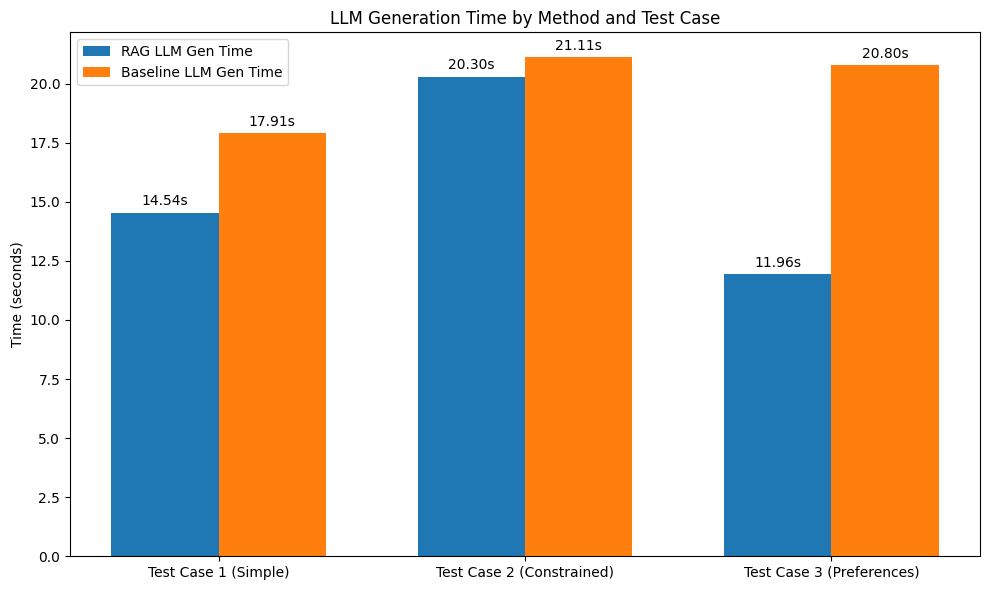

In [46]:
# --- Optional: Plotting Timing Results ---
# Ensure matplotlib.pyplot is imported (done in the previous cell now)

print("\n--- Generating Timing Plot ---")

if 'timing_data' in locals():
    labels = timing_data.keys()
    rag_times = [data["RAG"] for data in timing_data.values()]
    gen_times = [data["Baseline"] for data in timing_data.values()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed
    rects1 = ax.bar(x - width/2, rag_times, width, label='RAG LLM Gen Time')
    rects2 = ax.bar(x + width/2, gen_times, width, label='Baseline LLM Gen Time')

    # Add some text for labels, title and axes ticks
    ax.set_ylabel('Time (seconds)')
    ax.set_title('LLM Generation Time by Method and Test Case')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Optional: Add text labels on bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}s',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("Timing data not available. Run the comparison cell first.")